In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import json
from pathlib import Path

In [65]:
folder_path = "/content/drive/MyDrive/eval/Response Generation"

In [67]:
pattern = re.compile(r"query_answer_.*\.json") #Matches file name for which avergar word count has to be calculated
k_pattern = re.compile(r'k(\d+)', re.IGNORECASE)  # Matches 'k1', 'k3', etc.


In [68]:
parent_folders = ["contractnli", "cuad", "maud", "privacyqa"]
child_folders =["gpt","llama3"]


In [69]:
for folder in parent_folders:
  temp_folder = folder_path + "/" + folder
  for child in child_folders:
    temp_child_folder = temp_folder + "/" + child
    print(temp_child_folder)

/content/drive/MyDrive/eval/Response Generation/contractnli/gpt
/content/drive/MyDrive/eval/Response Generation/contractnli/llama3
/content/drive/MyDrive/eval/Response Generation/cuad/gpt
/content/drive/MyDrive/eval/Response Generation/cuad/llama3
/content/drive/MyDrive/eval/Response Generation/maud/gpt
/content/drive/MyDrive/eval/Response Generation/maud/llama3
/content/drive/MyDrive/eval/Response Generation/privacyqa/gpt
/content/drive/MyDrive/eval/Response Generation/privacyqa/llama3


In [70]:
results = []  # List to store results for each file

# Iterate through each parent folder (e.g., contractnli, cuad, etc.)
for parent in parent_folders:
    temp_folder = Path(folder_path) / parent  # Path to the current dataset folder

    # Iterate through each model subfolder (e.g., gpt, llama3)
    for child in child_folders:
        temp_child_folder = temp_folder / child  # Path to the current model folder

        # Iterate through all files in the current model folder
        for file in temp_child_folder.iterdir():
            # Proceed only if it's a .json file and matches the expected filename pattern
            if file.is_file() and file.suffix == ".json" and pattern.match(file.name):
                with open(file, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)  # Load JSON data
                        word_counts = []  # Store word count of each response in the file

                        # Iterate through each response item in the file
                        for item in data:
                            # Ensure the item is a dict and contains a "response" key
                            if isinstance(item, dict) and "response" in item:
                                response = item["response"]

                                # Check that the response is a string before processing
                                if isinstance(response, str):
                                    # Count words in the response and add to list
                                    word_counts.append(len(response.strip().split()))
                                else:
                                    print(f"Non-string response skipped in file: {file.name}")
                            else:
                                print(f"Missing or invalid 'response' in file: {file.name}")

                        # Compute total number of valid responses
                        num_responses = len(word_counts)

                        # Compute average word count if there are any valid responses
                        avg_words = sum(word_counts) / num_responses if num_responses else 0

                        # Extract the value of 'k' from the filename (e.g., k1, k3, k10)
                        match = k_pattern.search(file.name)
                        k_value = int(match.group(1)) if match else None

                        # Store the results in a structured format (dictionary)
                        results.append({
                            "parent_folder": parent,
                            "model": child,
                            "file_name": file.name,
                            "k_value": k_value,
                            "average_words_per_response": round(avg_words, 2),
                            "total_responses": num_responses
                        })

                    except json.JSONDecodeError:
                        # Handle JSON decoding issues
                        print(f"Error decoding JSON in file: {file.name}")


In [71]:
for i in results:
  print(i)
  print("\n")


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_baseline_gpt4omini_k1.json', 'k_value': 1, 'average_words_per_response': 29.26, 'total_responses': 194}


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_CoT_gpt4omini_k1.json', 'k_value': 1, 'average_words_per_response': 27.04, 'total_responses': 194}


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_manually_written_gpt4omini_k1.json', 'k_value': 1, 'average_words_per_response': 83.11, 'total_responses': 194}


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_baseline_gpt4omini_k3.json', 'k_value': 3, 'average_words_per_response': 45.0, 'total_responses': 194}


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_manually_written_gpt4omini_k3.json', 'k_value': 3, 'average_words_per_response': 90.31, 'total_responses': 194}


{'parent_folder': 'contractnli', 'model': 'gpt', 'file_name': 'query_answer_CoT_

In [72]:
print(len(results))

80


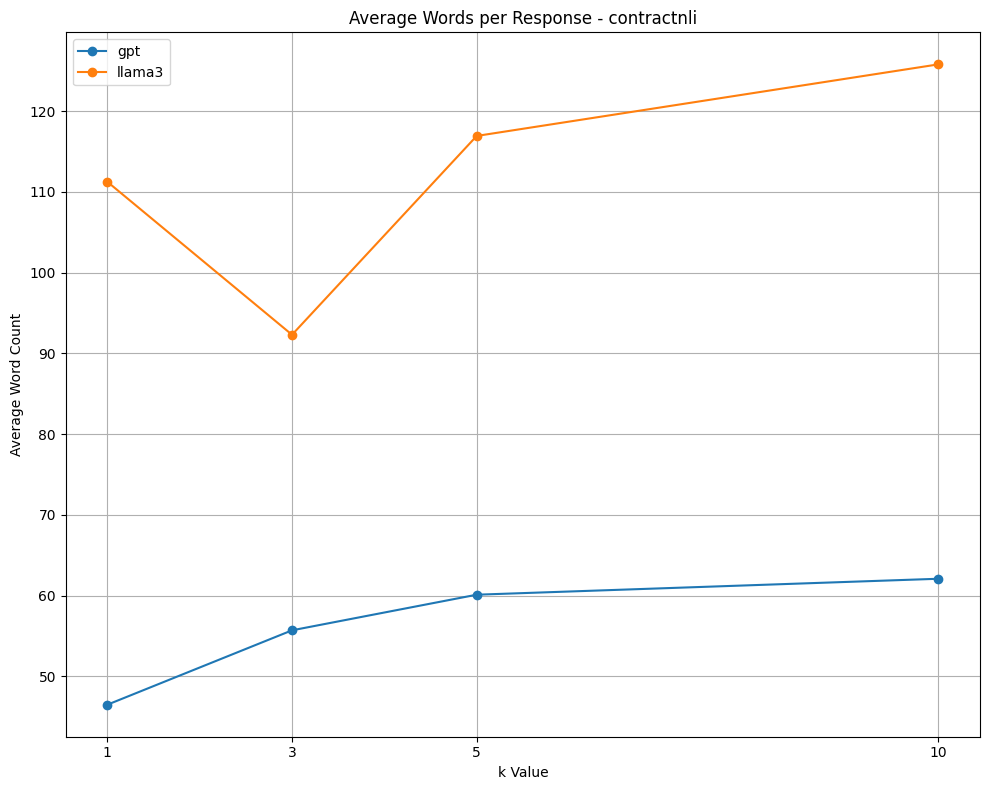

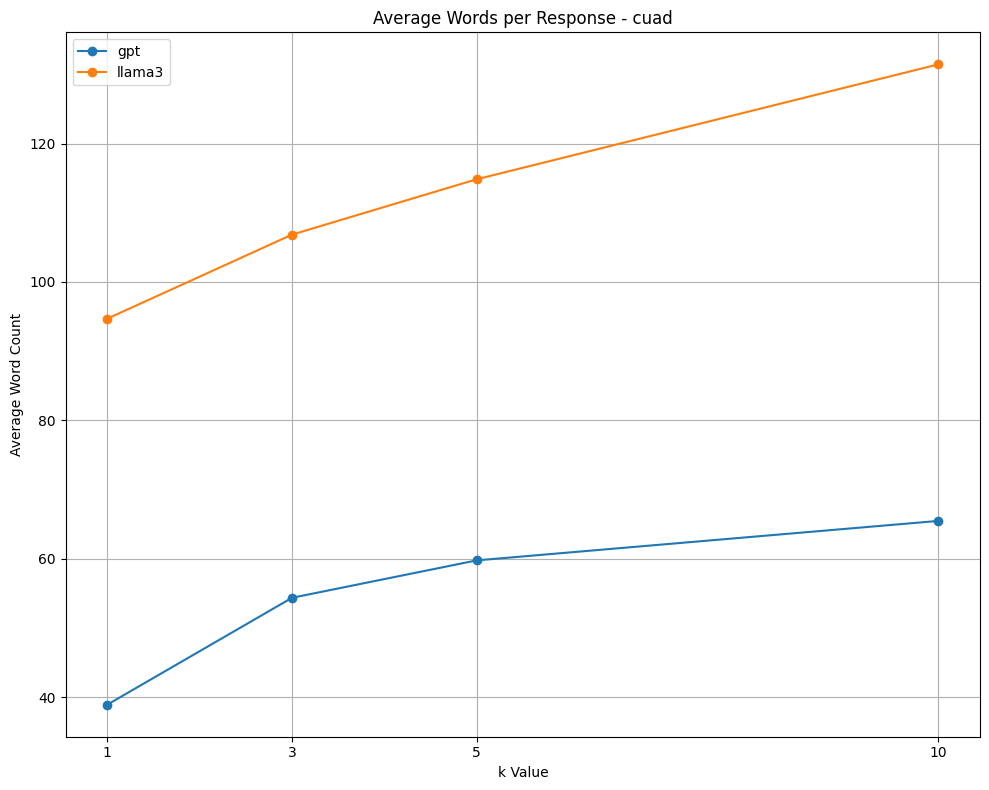

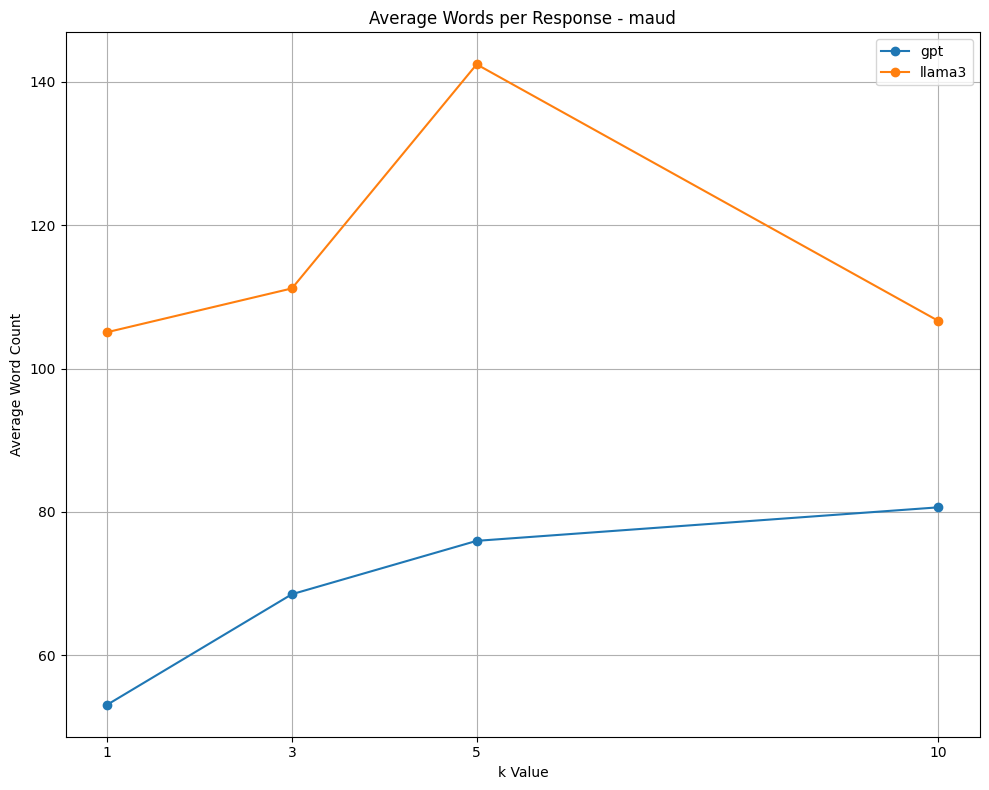

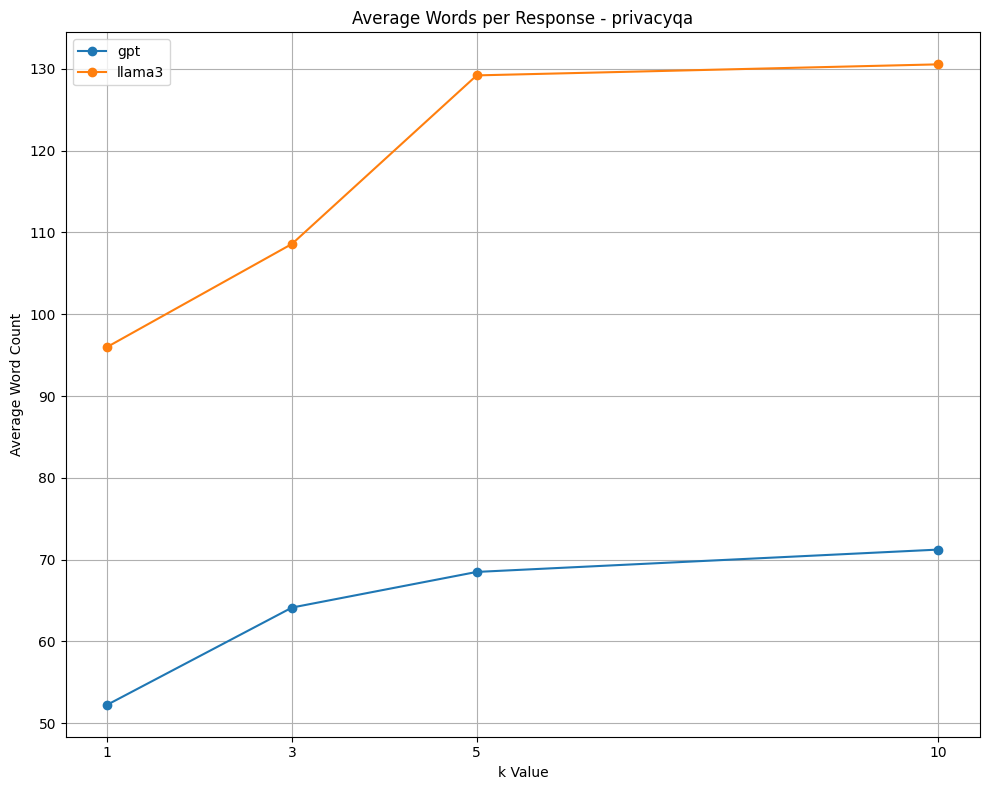

In [78]:
# ----------------------------------------------------------
# Step 1: Aggregate word counts for each (dataset, model, k)
# ----------------------------------------------------------
# We'll group all average word counts for combinations like:
# (contractnli, gpt, k=1), (cuad, llama3, k=5), etc.
# This allows us to average multiple files with the same settings.
aggregated_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
# Structure:
# {
#   dataset1: {
#     model1: {
#       k1: [avg1, avg2, ...],
#       k3: [...],
#     },
#     model2: {...}
#   },
#   dataset2: {...}
# }

# Loop through each result entry and group average word counts by dataset, model, and k
for item in results:
    dataset = item["parent_folder"]
    model = item["model"]
    k = item["k_value"]
    avg = item["average_words_per_response"]
    aggregated_data[dataset][model][k].append(avg)

# ---------------------------------------------------------------
# Step 2: Compute a single average per (dataset, model, k) group
# ---------------------------------------------------------------
# This step flattens the list of averages from Step 1 into a single mean value
grouped_data = defaultdict(lambda: defaultdict(dict))
# Structure after this step:
# {
#   dataset1: {
#     model1: {
#       k1: avg_over_all_files,
#       k3: avg_over_all_files,
#     },
#     ...
#   },
#   ...
# }

# Compute mean for each group of k values
for dataset, models in aggregated_data.items():
    for model, k_values in models.items():
        for k, avg_list in k_values.items():
            grouped_data[dataset][model][k] = sum(avg_list) / len(avg_list)

# -------------------------------------
# Step 3: Generate line plots per dataset
# -------------------------------------
# For each dataset (e.g., contractnli, cuad), create a line plot
# comparing GPT and LLaMA3 across different k-values

for dataset, model_data in grouped_data.items():
    plt.figure(figsize=(10, 8))  # Create a new figure for this dataset

    # Plot a line for each model
    for model in ["gpt", "llama3"]:
        if model in model_data:
            # Sort k-values to ensure consistent line progression
            sorted_items = sorted(model_data[model].items())  # [(1, avg), (3, avg), ...]
            ks, avgs = zip(*sorted_items)  # Separate into x and y lists
            plt.plot(ks, avgs, marker='o', label=model)  # Plot line for this model

    # Final touches on plot appearance
    plt.title(f"Average Words per Response - {dataset}")
    plt.xlabel("k Value")
    plt.ylabel("Average Word Count")
    plt.xticks([1, 3, 5, 10])  # Set specific x-axis ticks
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Display the plot


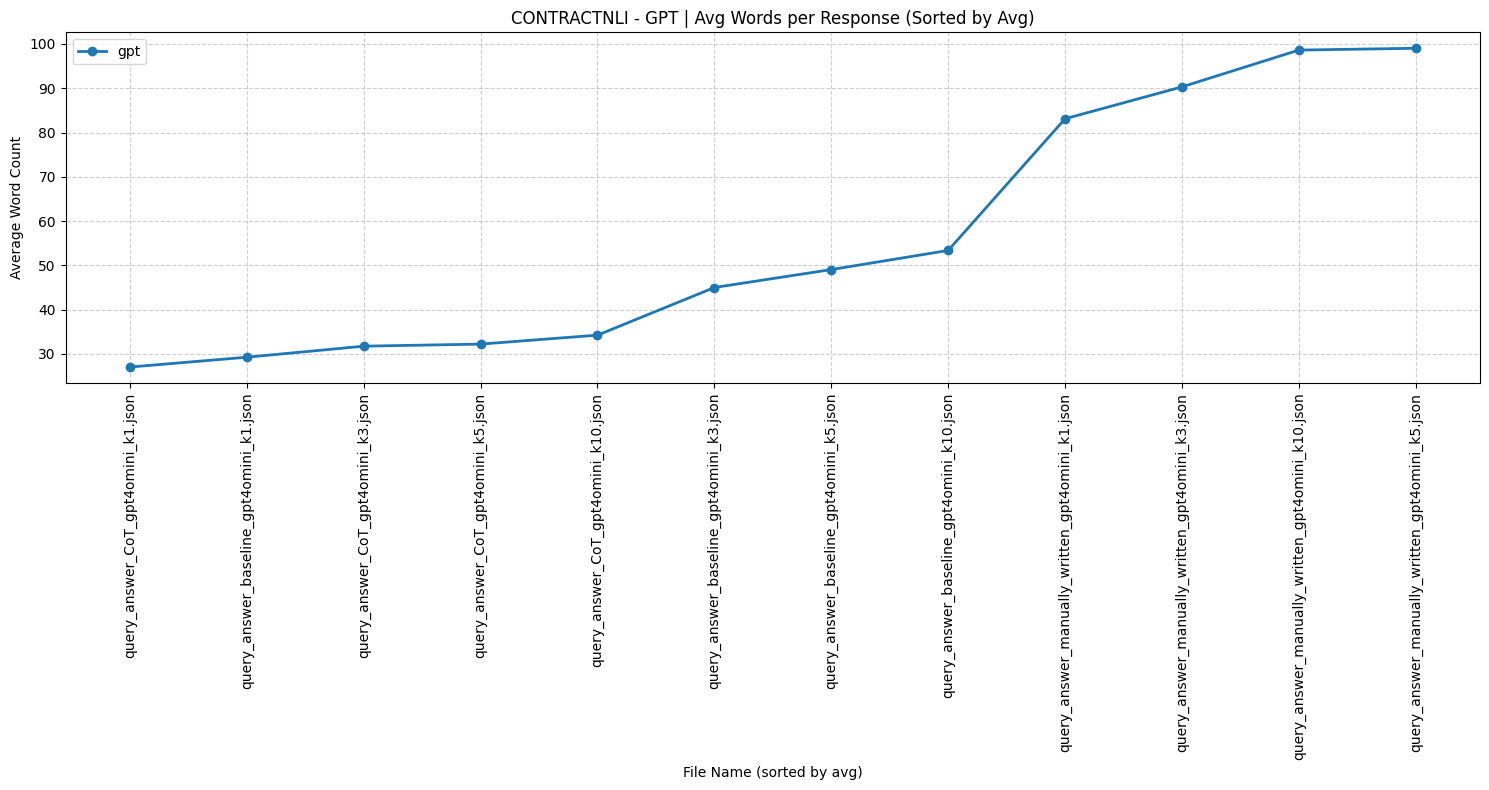

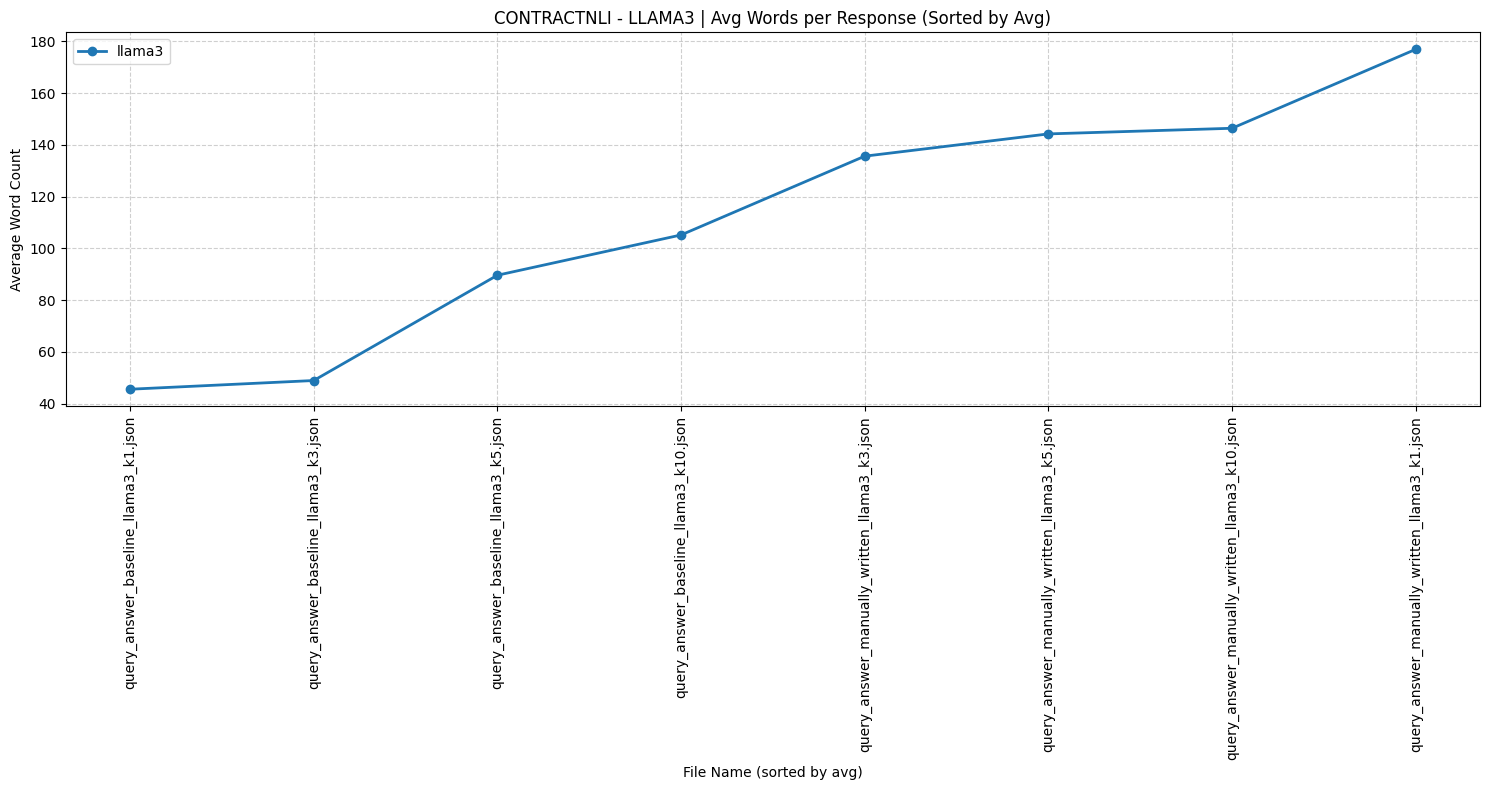

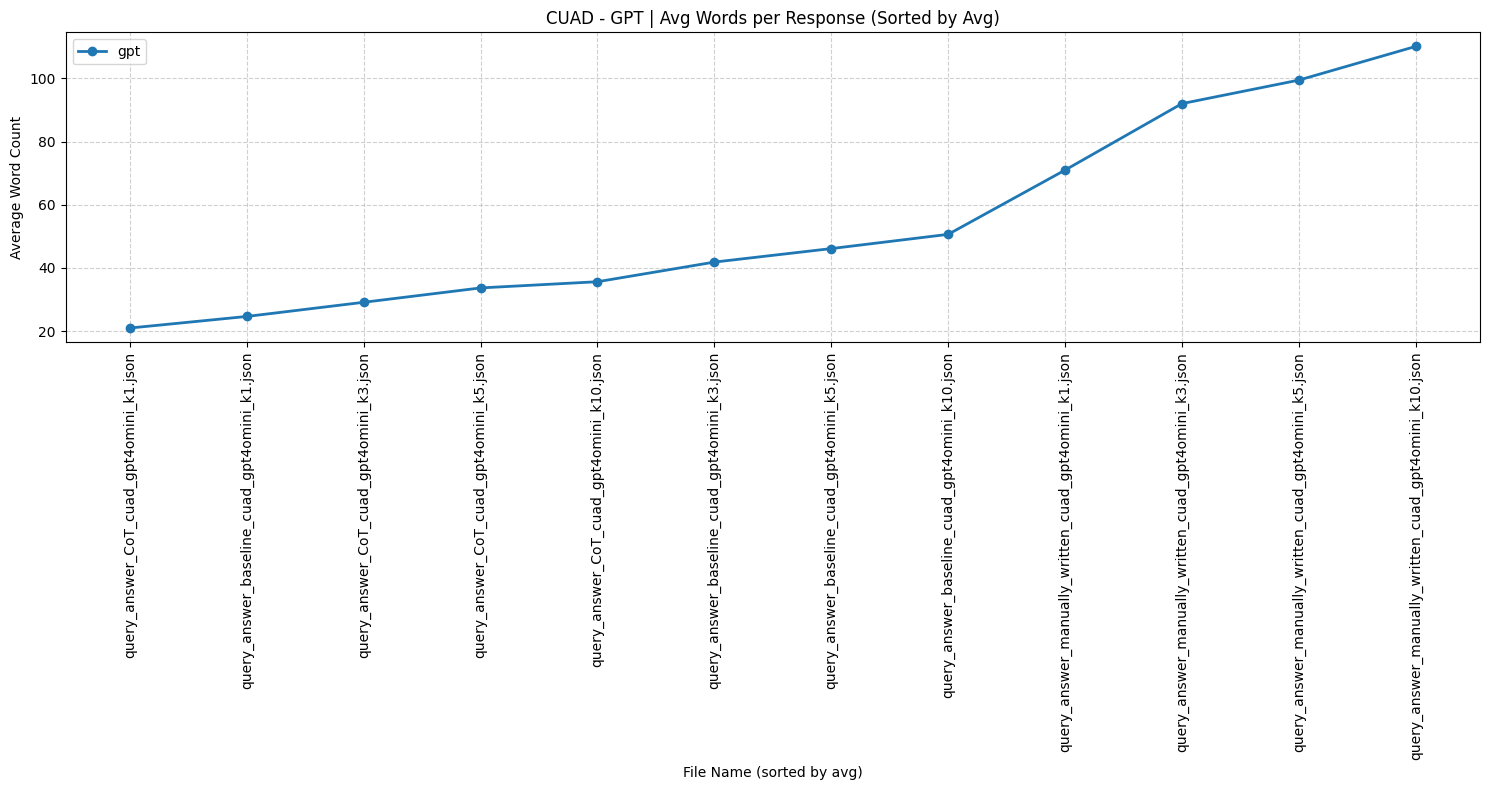

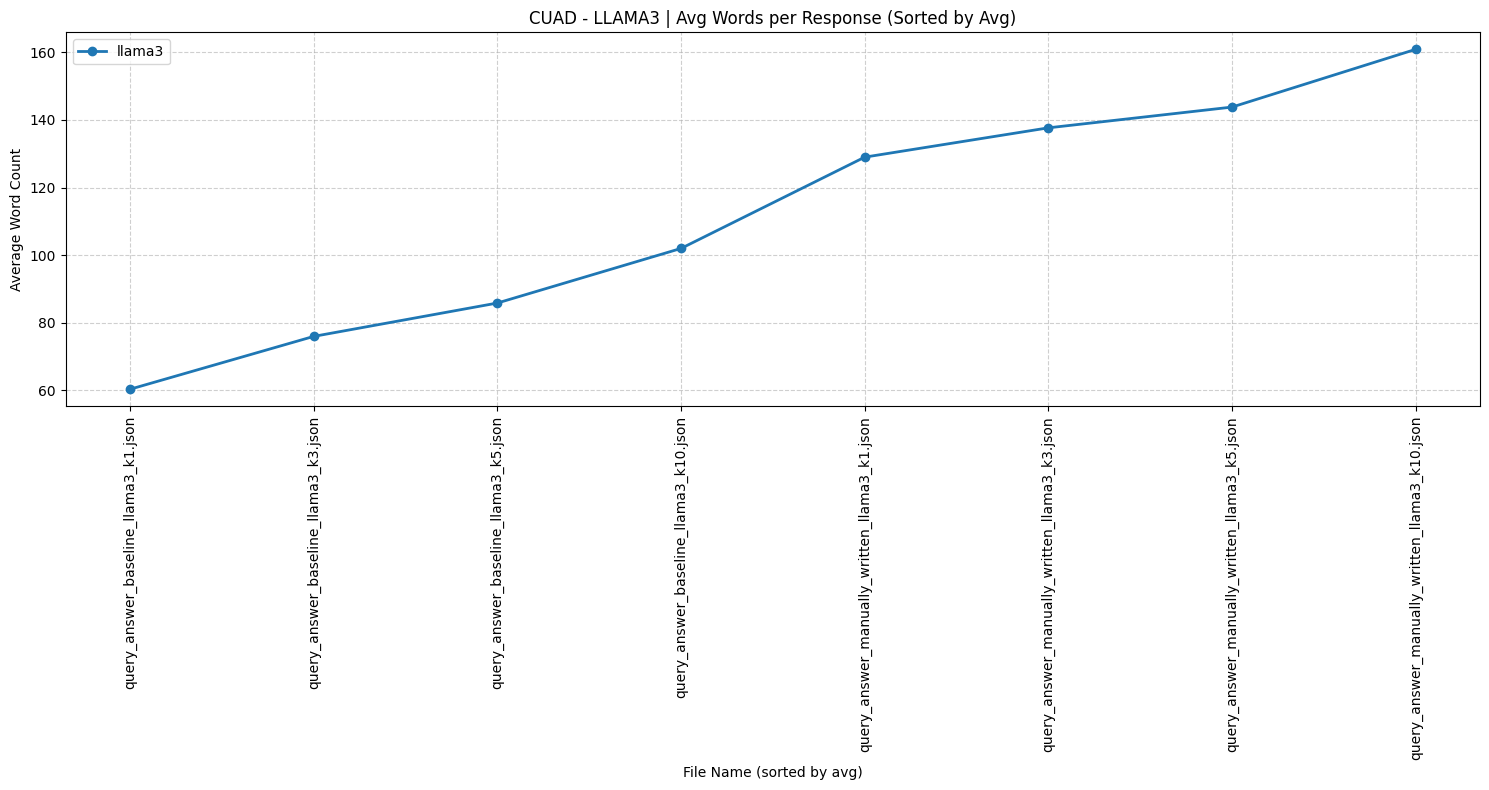

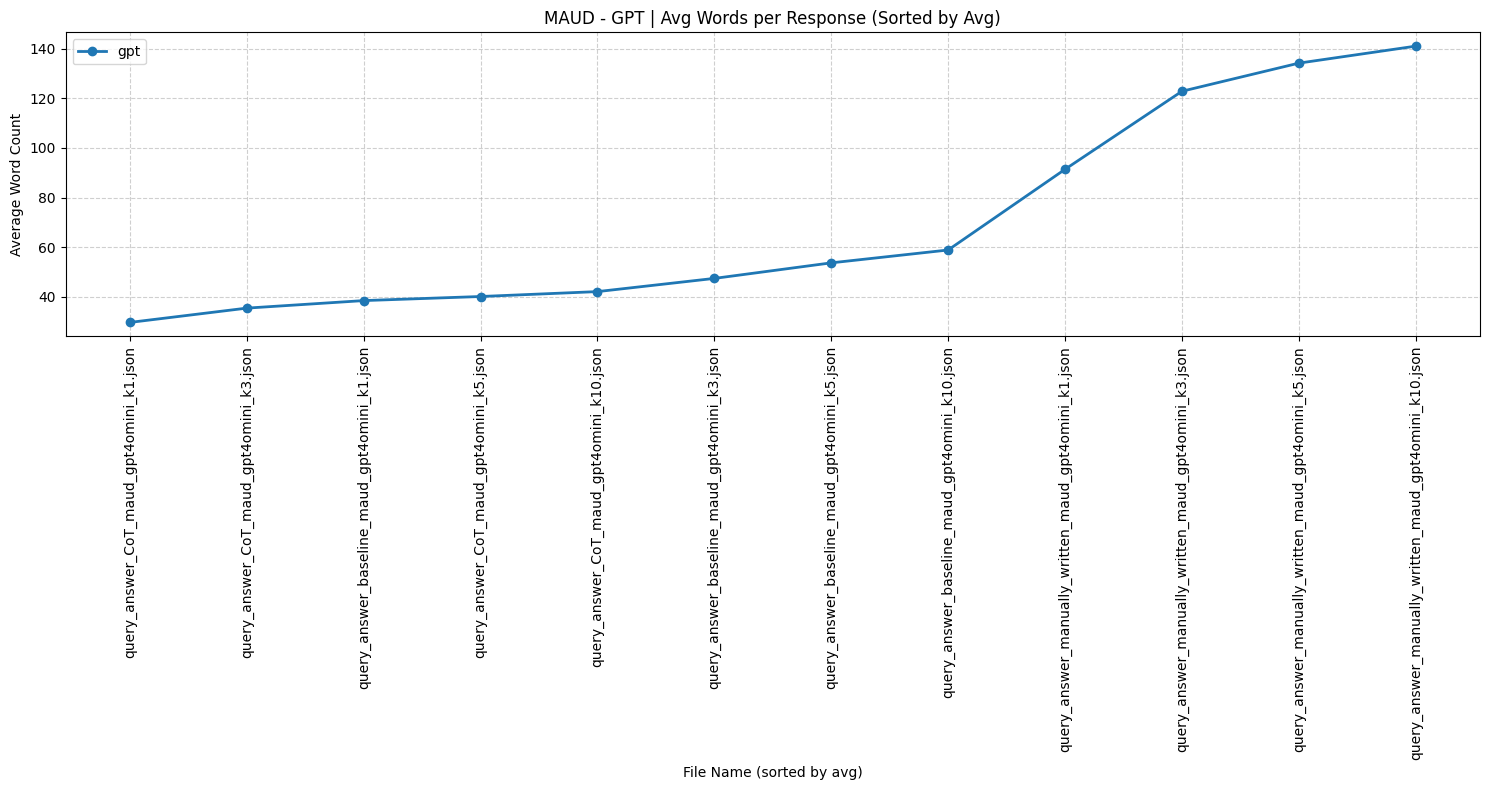

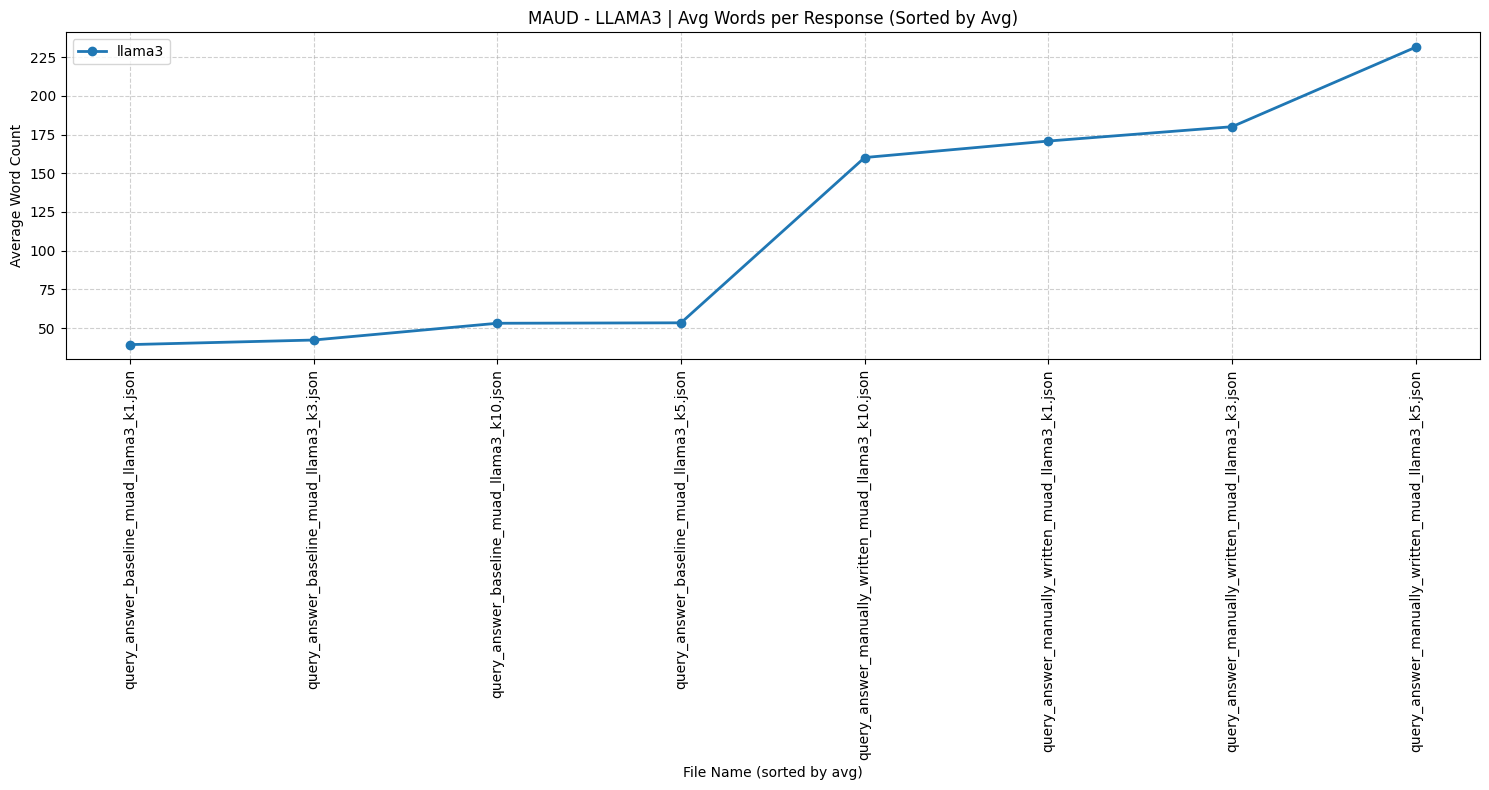

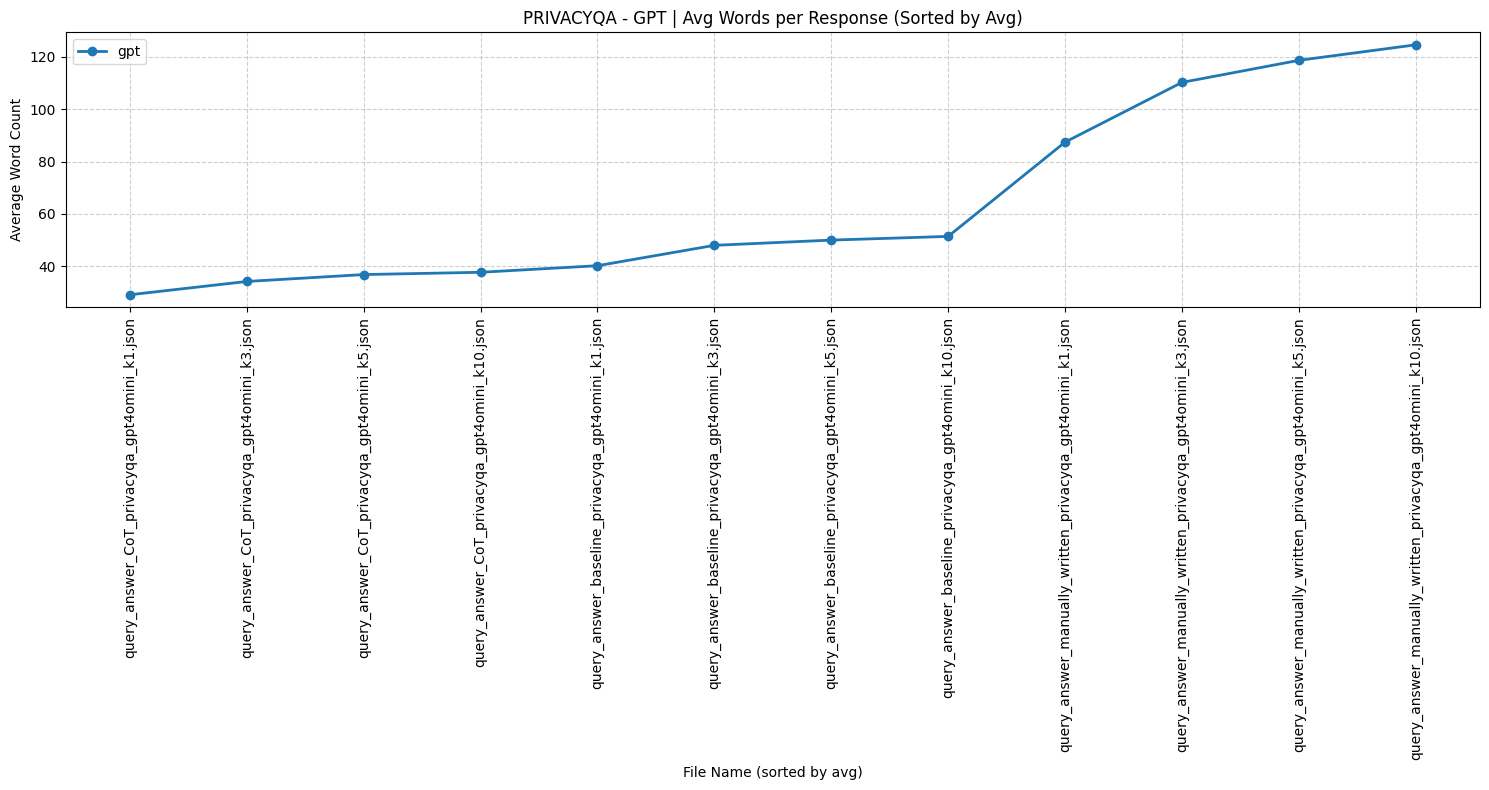

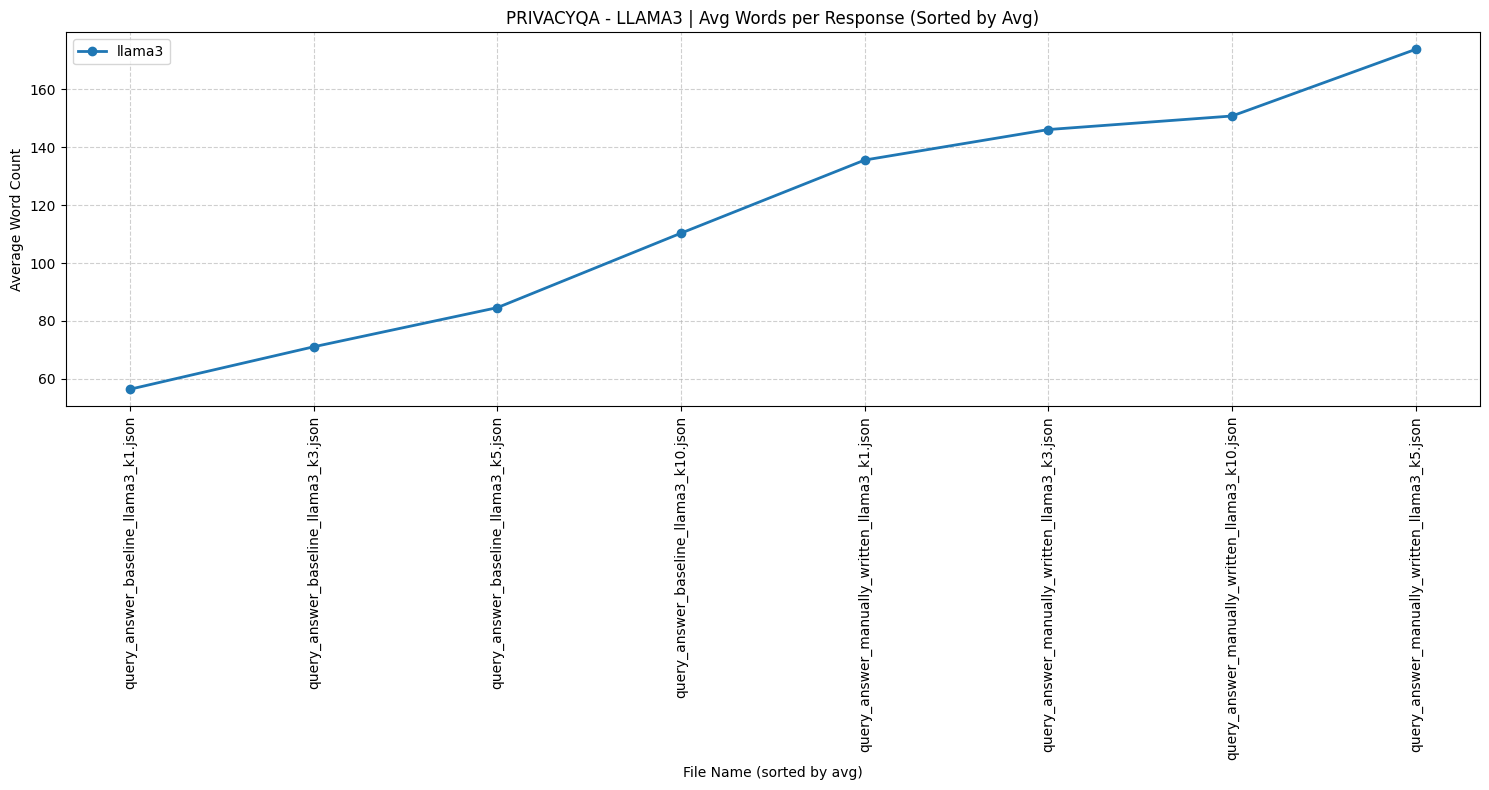

In [74]:

# -----------------------------------------
# Step 1: Group average word counts by file
# -----------------------------------------
# Structure: {dataset -> model -> file_name -> avg_word_count}
filewise_data = defaultdict(lambda: defaultdict(dict))

for item in results:
    dataset = item["parent_folder"]            # e.g., 'cuad'
    model = item["model"]                      # e.g., 'gpt'
    filename = item["file_name"]               # e.g., 'query_answer_gpt_k3.json'
    avg = item["average_words_per_response"]   # numeric value
    filewise_data[dataset][model][filename] = avg

# ---------------------------------------------------------
# Step 2: Line plot for each model separately per dataset
# Sorted by average word count, not file name
# ---------------------------------------------------------
for dataset, model_data in filewise_data.items():  # Loop through datasets
    for model in ["gpt", "llama3"]:                # One plot per model per dataset
        if model in model_data:
            plt.figure(figsize=(15, 8))  # Wider figure for clarity

            # Sort items by average word count (Y-axis) instead of file name
            sorted_items = sorted(model_data[model].items(), key=lambda x: x[1])
            file_names, avgs = zip(*sorted_items)

            # Create line plot with markers
            plt.plot(file_names, avgs, marker='o', linestyle='-', linewidth=2, label=model)

            # Aesthetics and labeling
            plt.title(f"{dataset.upper()} - {model.upper()} | Avg Words per Response (Sorted by Avg)")
            plt.xlabel("File Name (sorted by avg)")
            plt.ylabel("Average Word Count")
            plt.xticks(rotation=90)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.legend()
            plt.show()
